In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections.abc import Callable

import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import torch
from tqdm import tqdm
from transformer_lens import HookedTransformer
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

from teren.config import ExperimentConfig, Reference
from teren.perturbations import (
    NaiveRandomPerturbation,
    RandomPerturbation,
    RandomActivationPerturbation,
    SAEDecoderDirectionPerturbation,
    run_perturbation
)
from teren.utils import (
    generate_prompt,
    load_pretokenized_dataset,
    set_seed,
    get_device_str,
    set_seed
)

In [3]:
cfg = ExperimentConfig(
    n_ctx=10,
    perturbation_layer="blocks.1.hook_resid_pre",
    seed=3,
    dataloader_batch_size=15,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0.0, np.pi),
    #perturbation_range=(0.0, 1.0),
    n_steps=200,
    mean_batch_size=700,
    sae_threshold=0.1,
)

In [4]:
set_seed(cfg.seed)

In [5]:
dataset = load_pretokenized_dataset(
    path="apollo-research/Skylion007-openwebtext-tokenizer-gpt2", split="train"
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=cfg.dataloader_batch_size, shuffle=True
)

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/75 [00:00<?, ?it/s]

In [6]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [7]:
base_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
base_ref = Reference(
    model,
    base_prompt,
    cfg.perturbation_layer,
    cfg.read_layer,
    cfg.perturbation_pos,
    cfg.n_ctx,
)

In [8]:
print(base_prompt)

tensor([[  329,   262, 25098,   532,   290,   481,   629, 45828,   597,  5637]])


In [9]:
# Some experiment specific utils for converting a cov matrix
# to positive definite (we suspect it's because of smaller 
# batch size) needed for MultivariateNormal
def is_positive_definite(A):
    try:
        torch.linalg.cholesky(A)
        return True
    except RuntimeError:
        return False

def nearest_positive_definite(A):
    B = (A + A.T) / 2
    _, s, V = torch.svd(B)
    H = V.mm(torch.diag(s).mm(V.T))
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    if is_positive_definite(A3):
        return A3
    spacing = np.geomspace(torch.finfo(A.dtype).eps, 1, 10)
    for i in range(len(spacing)):
        mineig = torch.min(torch.real(torch.linalg.eigvals(A3)))
        A3 += torch.eye(A.shape[0]) * (-mineig * (1 + spacing[i]))
        if is_positive_definite(A3):
            return A3
    return A3



In [10]:
batch_of_prompts = generate_prompt(dataset, n_ctx=cfg.n_ctx, batch=cfg.mean_batch_size)
batch_act_cache = model.run_with_cache(batch_of_prompts)[1].to("cpu")
data = batch_act_cache[cfg.perturbation_layer][:, cfg.perturbation_pos, :].squeeze(1)
print(data.shape)
data_mean = data.mean(dim=0, keepdim=True)
data_cov = (
    torch.einsum("i j, i k -> j k", data - data_mean, data - data_mean) / data.shape[0]
)


torch.Size([700, 768])


In [11]:
# substitute covariance matrix with nearest that is positive definite
if not is_positive_definite(data_cov):
    data_cov = nearest_positive_definite(data_cov)

In [12]:
sae = get_gpt2_res_jb_saes(cfg.perturbation_layer)[0][cfg.perturbation_layer].to("cpu")

100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


In [13]:
unrelated_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
unrelated_ref = Reference(
    model,
    base_prompt,
    cfg.perturbation_layer,
    cfg.read_layer,
    cfg.perturbation_pos,
    cfg.n_ctx,
)

In [14]:
# Perturbations
naive_random_perturbation = NaiveRandomPerturbation()
random_perturbation = RandomPerturbation(data_mean, data_cov)
random_activation_perturbation = RandomActivationPerturbation(base_ref, dataset)
saedir_perturbation = SAEDecoderDirectionPerturbation(base_ref, unrelated_ref, sae, negate=-1, thresh=0.1)

perturbations = {
#     "naive random direction": naive_random_perturbation,
      "random direction": random_perturbation,
#     "direction to random other activation": random_activation_perturbation,
#    "direction of negative active SAE decoder feature": saedir_perturbation
}

Using active features: tensor([20427, 21958, 24149])


  0%|          | 0/1 [00:00<?, ?it/s]

Cosine similarity with final vector and base vector: 0.8850259780883789
base active SAE feature ids: [tensor([20427, 21958, 24149])]


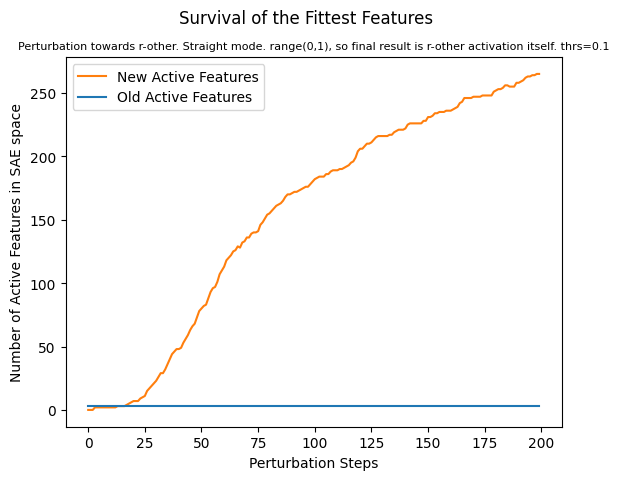

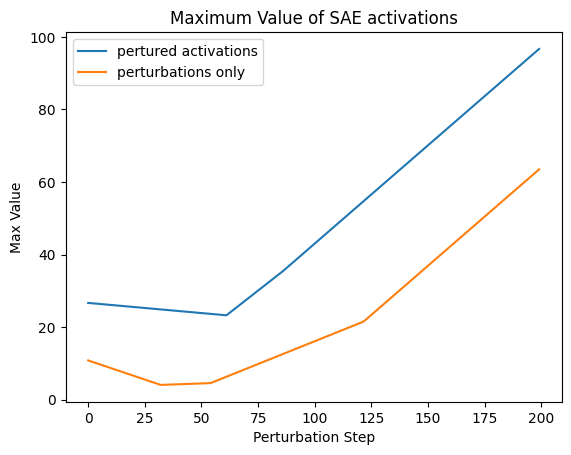

100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


In [15]:
results = defaultdict(list)

for _ in tqdm(range(1)):
    for name, perturbation in perturbations.items():
        kl_div = run_perturbation(cfg, base_ref, perturbation, sae)
        results[name].append(kl_div)


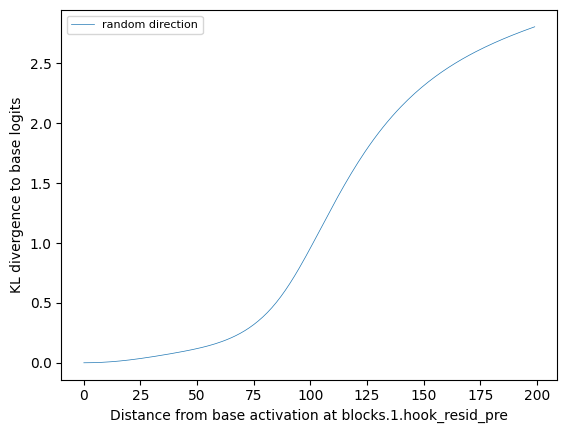

In [16]:
colors = {
    "random direction": "tab:blue",
    "naive random direction": "tab:purple",
    "direction to random other activation": "tab:orange",
    "direction of negative active SAE decoder feature": "tab:green"
}

for perturb_name in results.keys():
    for i, data in enumerate(results[perturb_name]):
        if i == 0:
            # Only label the first line for each perturb_name
            plt.plot(data, color=colors[perturb_name], label=perturb_name, linewidth=0.5)
        else:
            # Don't label subsequent lines to avoid duplicate legend entries
            plt.plot(data, color=colors[perturb_name], linewidth=0.5)

plt.legend(fontsize=8)
plt.ylabel("KL divergence to base logits")
plt.xlabel(f"Distance from base activation at {cfg.perturbation_layer}")
plt.show()

In [19]:
from teren.perturbations import scan
threshold = 0.1

def get_ids(act_features):
    return act_features.nonzero(as_tuple=True)[0]


def active_features_SAE(act, sae, threshold=0.05):
    #print("act shape in sae function:",act.shape)
    feature_acts = sae.encode(act)[0, -1, :]
    active_feature_ids = (
        feature_acts / feature_acts.max() > threshold
    ).to("cpu")
    act_str = feature_acts[active_feature_ids]
    return active_feature_ids, act_str

base_act = base_ref.cache[sae.cfg.hook_name]
print("base act shape:",base_act.shape)
base_act_features, base_act_str = active_features_SAE(base_act, sae, threshold)
base_ids = get_ids(base_act_features)
print("Using active features (base_ids):", base_ids)
print("Activation strengths are (act_str):", base_act_str)


base act shape: torch.Size([1, 10, 768])
Using active features (base_ids): tensor([20427, 21958, 24149])
Activation strengths are (act_str): tensor([26.6647,  5.1474,  5.1139])


In [20]:

perturbed_activations = scan(perturbation=random_perturbation, activations=base_ref.act, n_steps=cfg.n_steps, range=cfg.perturbation_range, sae=sae, cfg=cfg)
print(perturbed_activations.shape)
temp = [active_features_SAE(p_a.unsqueeze(0), sae, threshold) for p_a in perturbed_activations]
pert_sae_act = [temp[i][0] for i in range(len(temp))]
pert_sae_str = [temp[i][1] for i in range(len(temp))]


#perturbation_activations = perturbed_activations - 
#act_features_pert, act_str_pert = active_features_SAE()


Cosine similarity with final vector and base vector: 0.8801485300064087
torch.Size([200, 1, 768])


In [21]:
#print(pert_sae_act)
ids_list = [get_ids(act) for act in pert_sae_act]
#print(ids_list)
#print(pert_sae_str)
#print(pert_sae_str[150].max())
#print(ids_list[0])
#print(len(ids_list[50]))
print(ids_list[50])


max_values = [tensor.max().item() for tensor in pert_sae_str]


print(base_ids)

print(ids_list[0])


new_ids = [len([id for id in ids if id not in base_ids]) for ids in ids_list]





tensor([   11,   147,   277,   359,   384,   402,   418,   442,   451,   529,
          635,   809,   813,   985,  1032,  1159,  1168,  1369,  1454,  1552,
         1582,  1627,  1632,  1781,  1926,  1947,  1970,  2050,  2062,  2065,
         2119,  2224,  2244,  2458,  2498,  2553,  2579,  2599,  2712,  2745,
         2838,  2913,  2929,  2973,  2997,  3052,  3058,  3117,  3253,  3289,
         3321,  3378,  3387,  3601,  3880,  3945,  4012,  4083,  4123,  4133,
         4227,  4261,  4372,  4391,  4473,  4732,  4790,  4810,  4889,  4907,
         4931,  4948,  4963,  4965,  4997,  4998,  5063,  5082,  5160,  5179,
         5189,  5264,  5276,  5363,  5377,  5519,  5554,  5644,  5739,  5742,
         5751,  5778,  5798,  5881,  5933,  5993,  6016,  6051,  6118,  6131,
         6229,  6503,  6549,  6701,  6746,  6941,  7055,  7124,  7137,  7141,
         7199,  7218,  7237,  7287,  7358,  7389,  7467,  7538,  7798,  7975,
         7996,  8033,  8143,  8298,  8404,  8466,  8614,  8637, 

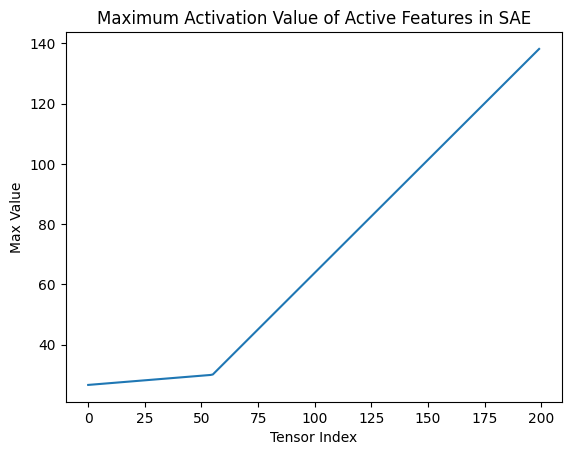

In [22]:
from matplotlib.ticker import FuncFormatter
def to_percentage(x, _):
    return f"{100 * x / (len(max_values)):.0f}%"

plt.plot(max_values, label='Max Value')
plt.xlabel('Tensor Index')
plt.ylabel('Max Value')
plt.title('Maximum Activation Value of Active Features in SAE')
#plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percentage))
plt.show()

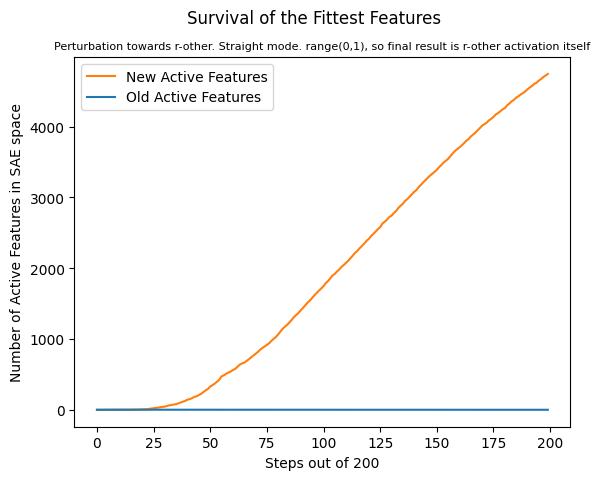

In [23]:
old_ids = [len([id for id in base_ids if id in ids]) for ids in ids_list]
plt.plot(new_ids, color= "tab:orange", label='New Active Features')
plt.plot(old_ids, color="tab:blue", label='Old Active Features')
plt.xlabel(f'Steps out of {cfg.n_steps}')
plt.ylabel('Number of Active Features in SAE space')
plt.suptitle('Survival of the Fittest Features')
plt.title('Perturbation towards r-other. Straight mode. range(0,1), so final result is r-other activation itself', fontsize = 8)
plt.legend()
plt.show()